# Машинное обучение, DS-поток, осень 2024
## Задание ML.11

In [ ]:
!pip install pytorch_lightning
!pip install torcheval
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from shutil import copyfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import glob
import os
import shutil

import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.model_selection import train_test_split

import wandb
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint

In [ ]:
sns.set(style='darkgrid', palette='Set2')
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Bot check

# HW_ID: ds_ml11
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

## Задача 1. Transfer learning
Вы научите нейронную сеть классифицировать произведения искусства различных художников, т.е. определять к какому художнику относится картина.

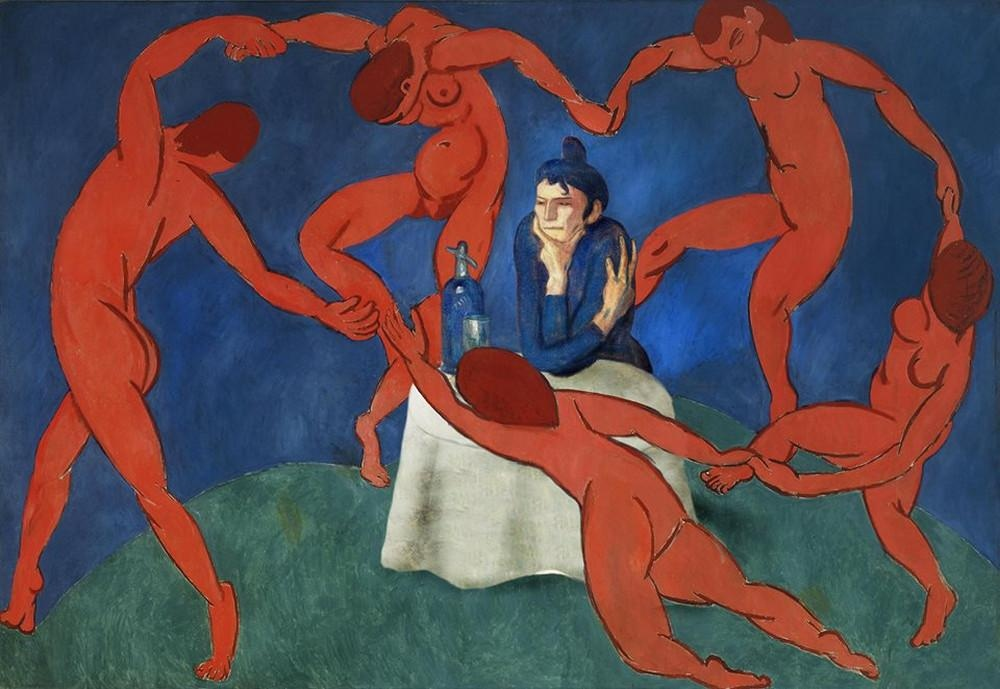

### 1. Данные
Скачайте архив с датасетом по [ссылке](https://disk.yandex.ru/d/_BUueJa4RVXplQ).

Для того, чтобы разархивировать данные, выполните следующие действия.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Запишите путь до архива.
zip_path = '/content/drive/MyDrive/Colab_Notebooks/DS_5term/week_11/artworks.zip'
# Замените пробелы в пути, чтобы следующая bash-команда работала корректно.
zip_path_bash = str(zip_path).replace(' ', '\ ')
# Разархивируйте файлы.
!unzip $zip_path_bash -d .
# Укажите путь до данных.
data_path = Path('./artworks')

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_472.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_265.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_122.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_636.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_328.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_166.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_203.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_577.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_649.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_429.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_518.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_348.jpg  
  inflating: ./artworks/images/train/Edgar_Degas/Edgar_Degas_216.jpg  
  inflati

Данные содержат папку с изображениями `images` и таблицу с основной информацией про художников `artists.csv`. Папка `images` в свою очередь состоит из папок `train` и `test` с обучающим и тестовым наборами данных соответственно. Рассмотрим, например, папку с тренировочным набором данных.

In [ ]:
sorted((data_path / 'images' / 'train').iterdir())

[PosixPath('artworks/images/train/Albrecht_Durer'),
 PosixPath('artworks/images/train/Alfred_Sisley'),
 PosixPath('artworks/images/train/Amedeo_Modigliani'),
 PosixPath('artworks/images/train/Andrei_Rublev'),
 PosixPath('artworks/images/train/Andy_Warhol'),
 PosixPath('artworks/images/train/Camille_Pissarro'),
 PosixPath('artworks/images/train/Caravaggio'),
 PosixPath('artworks/images/train/Claude_Monet'),
 PosixPath('artworks/images/train/Diego_Rivera'),
 PosixPath('artworks/images/train/Diego_Velazquez'),
 PosixPath('artworks/images/train/Edgar_Degas'),
 PosixPath('artworks/images/train/Edouard_Manet'),
 PosixPath('artworks/images/train/Edvard_Munch'),
 PosixPath('artworks/images/train/El_Greco'),
 PosixPath('artworks/images/train/Eugene_Delacroix'),
 PosixPath('artworks/images/train/Francisco_Goya'),
 PosixPath('artworks/images/train/Frida_Kahlo'),
 PosixPath('artworks/images/train/Georges_Seurat'),
 PosixPath('artworks/images/train/Giotto_di_Bondone'),
 PosixPath('artworks/images/t

Она содержит папки, соответствующие художникам в датасете. В каждой такой папке находится тренирвочный набор картин художника.

In [ ]:
sorted((data_path / 'images' / 'train' / 'Albrecht_Durer').iterdir())

[PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_001.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_002.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_004.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_005.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_006.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_007.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_008.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_010.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_011.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_012.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_013.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_016.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_018.jpg'),
 PosixPath('artworks/imag

Приведем примеры изображений.

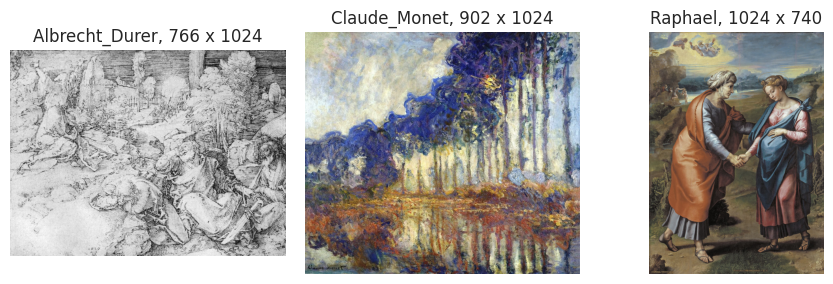

In [ ]:
images_paths = [
    data_path / 'images' / 'train' / 'Albrecht_Durer' / 'Albrecht_Durer_310.jpg',
    data_path / 'images' / 'train' / 'Claude_Monet' / 'Claude_Monet_007.jpg',
    data_path / 'images' / 'train' / 'Raphael' / 'Raphael_100.jpg'
]
plt.figure(figsize=(9, 3))
for i, image_path in enumerate(images_paths):
    author = image_path.parent.name
    plt.subplot(1, 3, i + 1)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f'{author}, {image.shape[0]} x {image.shape[1]}')
    plt.axis("off")
plt.tight_layout()

Заметьте, что все картины разных пропорций и размеров, это нужно учесть при обучении модели. Чтобы привести картины к одному размеру можно использовать аугментации, см. пример с Симпсонами в семинаре.


Теперь посмотрим на таблицу с характеристиками художников.



In [ ]:
data = pd.read_csv(data_path / 'artists.csv')
data.head()

,name,years,genre,nationality,bio,wikipedia,paintings
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


Наша цель &mdash; построить классификатор картин по художникам. В колонке `paintings` указано общее число картин для каждого худодника. Можно заметить большую несбалансированность классов. Поэтому в начале мы будем работать с художниками, для которых в сумме представлено не менее 200 картин.

In [ ]:
data_ge200 = data.query('paintings >= 200')
data_ge200

,name,years,genre,nationality,bio,wikipedia,paintings
8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336
16,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
20,Alfred Sisley,1839 - 1899,Impressionism,"French,British",Alfred Sisley (; French: [sislɛ]; 30 October 1...,http://en.wikipedia.org/wiki/Alfred_Sisley,259
22,Marc Chagall,1887 - 1985,Primitivism,"French,Jewish,Belarusian",Marc Zakharovich Chagall ( shə-GAHL; born Mois...,http://en.wikipedia.org/wiki/Marc_Chagall,239
30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255


Для обучения вам понадобится построить датасет. Удобнее всего будет воспользоваться `torchvision.datasets.ImageFolder`, см. пример в семинаре с Симпсонами.

In [ ]:
ge_200_paintings = set(map(lambda x: x.replace(' ', '_'), data_ge200['name'].to_list()))
input_size = 512

# Трансформация для картин, чтобы привести их к единому размеру
resize_and_crop = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

In [ ]:
tmp_dir = data_path / "images_ge200"
os.makedirs(str(tmp_dir), exist_ok=True)
for name in ge_200_paintings:
    dir = data_path / "images" / "train" / name
    for curr_path in glob.glob(str(dir) + '/*.jpg'):
        img_name = str(Path(curr_path).name)
        tmp_path = tmp_dir / 'train' / name
        os.makedirs(str(tmp_path), exist_ok=True)
        shutil.copy2(curr_path, tmp_path)

# Обучающий датасет
train_dataset = ImageFolder(
    tmp_dir / 'train',
    transform=resize_and_crop,
    is_valid_file=lambda x: Path(x).parent.name in ge_200_paintings,
)

In [ ]:
for name in ge_200_paintings:
    dir = data_path / "images" / "test" / name
    for curr_path in glob.glob(str(dir) + '/*.jpg'):
        img_name = str(Path(curr_path).name)
        tmp_path = tmp_dir / 'test' / name
        os.makedirs(str(tmp_path), exist_ok=True)
        shutil.copy2(curr_path, tmp_path)

val_dataset = ImageFolder(
    tmp_dir / 'test',
    transform=resize_and_crop,
    is_valid_file=lambda x: Path(x).parent.name in ge_200_paintings,
)

In [ ]:
print('Количество классов:', len(train_dataset.classes))
print('Количество картин в обучающей выборке:', len(train_dataset))

Количество классов: 10
Количество картин в обучающей выборке: 2775


Посмотрим на примеры картинок в обучающем датасете

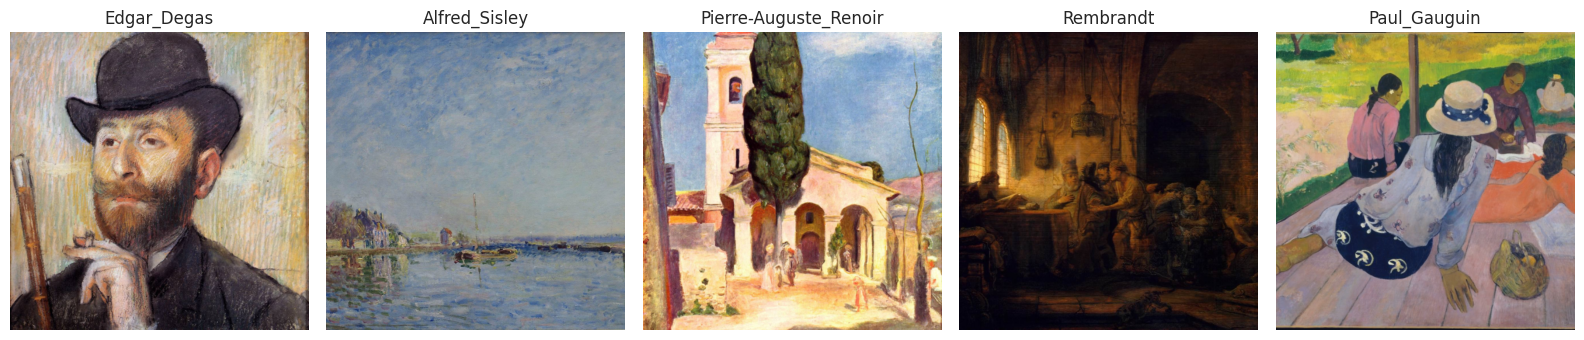

In [ ]:
sns.set_style(style='white')
fig, axs = plt.subplots(
    nrows=1, ncols=5, figsize=(16, 4),
    sharey=True, sharex=True
)

for i in range(5):
    idx = np.random.randint(low=0, high=2775)
    img, label = train_dataset[idx]
    axs[i].set_title(train_dataset.classes[label])
    axs[i].axis('off')
    axs[i].imshow(img.numpy().transpose((1, 2, 0)))
plt.tight_layout()

### 2. Fine-tuning
Выберите одну из моделей [здесь](https://pytorch.org/vision/stable/models.html) для fine-tuning, архитектуру которой мы разбирали на лекции. Поясните свой выбор.

**Ответ:** Будем использовать ResNeXt модель, так как она является одной из самых лучших моделей и при это объединяет в себе сразу несколько интересных идей, рассмотренных на лекции: residual блоки, inception блоки и grouped convolution.

Как вы думаете, какой вариант fine-tuning больше подходит для данной задачи?

**Ответ:** ResNeXt предобучена на датасете ImageNet, который, в целом расходится с имеющимся у нас датасетом. Например некоторые художники в своих картинах могут изображать нечто странное и несуществующее (_это хорошо видно в примерах выше_). Таким образом скорее всего в данной задаче Fine Tuning подойдет больше, чем Feature Extractor

Создадим класс модели для Pytorch Lightning:

In [ ]:
from torchvision.models import resnext50_32x4d
from torcheval.metrics.functional import multiclass_f1_score as f1_score

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

class FineTunedNet(LightningModule):
    def __init__(self, to_freeze, n_classes, lr=0.001):
      '''Инициализация модели
      * to_freeze -- сколько слоев хотим заморозить.
      * n_classes -- кол-во классов'''

      super().__init__()
      self.n_classes = n_classes
      self.lr = lr
      self.criterion = nn.CrossEntropyLoss()
      self.train_step_outputs = []
      self.val_step_outputs = []

      # Загружаем предобученную модель
      pretrained_model = resnext50_32x4d(weights='ResNeXt50_32X4D_Weights.DEFAULT')
      layers = list(pretrained_model.children())[:-1]
      self.resnext = nn.Sequential(*layers)

      # Замораживаем первые to_freeze слоев
      assert to_freeze <= len(layers)
      for layer_idx in range(to_freeze):
        for param in self.resnext[layer_idx].parameters():
            param.requires_grad = False

      # Строим классификатор
      in_features = pretrained_model.fc.in_features
      self.fc = nn.Linear(in_features, n_classes, bias=True)

    def forward(self, x):
      self.resnext.eval()
      self.fc.eval()
      logits = self.resnext(x).flatten(1)
      logits = self.fc(logits)
      return logits

    def configure_optimizers(self):
      '''Определяет оптимизатор модели'''
      return torch.optim.SGD(self.parameters(), self.lr)

    def training_step(self, batch, batch_idx):
      '''Возвращает лосс с 1 шага обучения по батчу'''
      preds, loss = self.__get_preds_loss(batch)
      self.train_step_outputs.append(preds)
      self.log('train_loss', loss)
      return loss

    def validation_step(self, batch, batch_idx):
      '''Используется для логирования метрик'''
      preds, loss = self.__get_preds_loss(batch)
      self.val_step_outputs.append(preds)
      self.log('val_loss', loss)
      return preds


    def __get_preds_loss(self, batch):
      '''вспомогательная функция для шага обучения / валидации'''
      x, y = batch
      logits = self(x)
      preds = torch.argmax(logits, dim=1)
      loss = self.criterion(logits, y)
      return preds, loss

In [ ]:
class LogPredictionsCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
      epoch_outputs = torch.cat(pl_module.train_step_outputs).to('cpu')

      epoch_labels = []
      for _, y_batch in trainer.train_dataloader:
          epoch_labels.append(y_batch)
      epoch_labels = torch.cat(epoch_labels)

      f1 = f1_score(epoch_outputs, epoch_labels, average='macro', num_classes=pl_module.n_classes)
      pl_module.log("train_epoch_f1_score", f1)
      pl_module.train_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
      epoch_outputs = torch.cat(pl_module.val_step_outputs).to('cpu')

      epoch_labels = []
      num_butches = len(pl_module.val_step_outputs)
      i = 0
      for _, y_batch in trainer.val_dataloaders:
          epoch_labels.append(y_batch)
          i += 1
          if i == num_butches:
            break
      epoch_labels = torch.cat(epoch_labels)

      f1 = f1_score(epoch_outputs, epoch_labels, average='macro', num_classes=pl_module.n_classes)
      pl_module.log("val_epoch_f1_score", f1)
      pl_module.val_step_outputs.clear()

log_predictions_callback = LogPredictionsCallback()

In [ ]:
batch_size = 16

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Попробуйте fine-tuning с разным количеством размороженных слоев, достаточно трех вариантов. Сравните ошибку (лосс) и качество (F1 macro) на тренировочной и тестовой частях выборки во время обучения. F1 Score считайте не на каждом батче, а на всей эпохе. Для этого можно воспользоваться методами `on_train_epoch_end` и `on_validation_epoch_end`.

Посмотрим на количество Feature Extractor слоев в нашей модели

In [ ]:
len(list(resnext50_32x4d(weights='ResNeXt50_32X4D_Weights.DEFAULT').children())[:-1])

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 175MB/s]


9

### Первая модель
Заморожено 3/9 слоев

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor='val_epoch_f1_score', mode='max')
wandb_logger = WandbLogger(project='ML.11', log_model='all')
trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[log_predictions_callback,
              checkpoint_callback],         # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=10)

finetuned_model = FineTunedNet(3, 10)
trainer.fit(finetuned_model, training_loader, validation_loader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | resnext   | Sequential       | 23.0 M | train
2 | fc        | Linear           | 20.5 K | train
-------------------------------------------------------
23.0 M    Trainable params
9.5 K     Non-trainable params
23.0 M    Total params
92.002    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
train_epoch_f1_score,▁▃▆▇▇▅█▅▆█
train_loss,▇█▆▅▃▄▃▄▄▃▄▄▃▄▃▂▂▁▂▂▅▂▄▃▂▃▂▂▁▃▃▃▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_epoch_f1_score,▁▄▅▇▆▆▇▇█▇
val_loss,█▅▄▃▃▃▂▂▁▂
epoch,9
train_epoch_f1_score,0.10523
train_loss,0.22165
trainer/global_step,1739
val_epoch_f1_score,0.78196


### Вторая модель
Заморожено 6/9 слоев

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor='val_epoch_f1_score', mode='max')
wandb_logger = WandbLogger(project='ML.11', log_model='all')
trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[log_predictions_callback,
              checkpoint_callback],         # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=15)

finetuned_model_1 = FineTunedNet(6, 10)
trainer.fit(finetuned_model_1, training_loader, validation_loader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | resnext   | Sequential       | 23.0 M | train
2 | fc        | Linear           | 20.5 K | train
-------------------------------------------------------
21.6 M    Trainable params
1.4 M     Non-trainable params
23.0 M    Total params
92.002    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
train_epoch_f1_score,▁▅▄▄▅▆█▅▅▄▄▅▅▅▅
train_loss,██▇▆▅▃▃▃▄▃▂▂▃▂▂▂▁▂▁▂▁▂▂▃▁▂▂▂▁▁▁▂▁▂▂▂▁▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_epoch_f1_score,▁▆▅▇▇▇▇▇▇██████
val_loss,█▄▆▃▂▂▂▂▃▁▂▁▁▁▁
epoch,14
train_epoch_f1_score,0.10259
train_loss,0.0716
trainer/global_step,2609
val_epoch_f1_score,0.85024


### Третья модель
Заморожено 9/9 слоев

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor='val_epoch_f1_score', mode='max')
wandb_logger = WandbLogger(project='ML.11', log_model='all')
trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[log_predictions_callback,
              checkpoint_callback],         # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=10)

finetuned_model_2 = FineTunedNet(9, 10)
trainer.fit(finetuned_model_2, training_loader, validation_loader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | resnext   | Sequential       | 23.0 M | train
2 | fc        | Linear           | 20.5 K | train
-------------------------------------------------------
20.5 K    Trainable params
23.0 M    Non-trainable params
23.0 M    Total params
92.002    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
train_epoch_f1_score,█▁▁▁▂▅▃▄▇▆
train_loss,█▇▆▇▆▆▅▄▆▃▆▄▅▆▃▃▃▄▄▆▃▃▂▂▃▄▂▁▄▃▁▂▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_epoch_f1_score,▁▁▂▂▃▄▅▆▇█
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,9
train_epoch_f1_score,0.07914
train_loss,1.47133
trainer/global_step,1739
val_epoch_f1_score,0.40709


Поясните, в чем преимущества F1 macro по сравнению с accuracy. Сделайте выводы.

**Вывод:**
- F1 macro: вычисляем F1-score для каждого класса, а затем усредняем по всем классам. Так как F1-score не зависит от размера класса, итоговая метрика многоклассофой классификации обладает устойчивостью к дисбалансам классов. Но у accuracy этого свойства нет.
- Наше предположение подтвердилось наилучшую метрику на валидациии показала модель у которой заморожены не все feature extractor слои. При этом модель, у которой 67% заморожены, окащалось лучше модели с 33% замороженных слоев

### 3. Аугментации

Для улучшения качества модели можно расширить обучающую выборку. Это можно сделать с помощью аугментации данных. Подумайте, какие аугментации здесь будут полезны, напишите свой ответ.

**Ответ:**
1. Было бы неплохо добавить афинные преобразования изображений. Так как мы производим обрезку картин (уменьшаем, и вырезаем квадрат в центре), то было бы неплохо для начала производить поворот и смещение. Таким образом, из-за того, что центр сместится, после обрезки мы получим изображение с новой информацией

2. Так же добавим рандомные изменения яркости, контраста и насыщенности

Добавьте аугментации к данным. Визуализируйте несколько аугментированных изображений.

In [ ]:
# Трансформация для картин, чтобы привести их к единому размеру
train_transform = transforms.Compose([
    transforms.RandomAffine(5, (0.1, 0.1)),
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6),
    transforms.ToTensor(),
])

# Обучающий датасет
train_dataset_aug = ImageFolder(
    tmp_dir / 'train',
    transform=train_transform,
    is_valid_file=lambda x: Path(x).parent.name in ge_200_paintings,
)

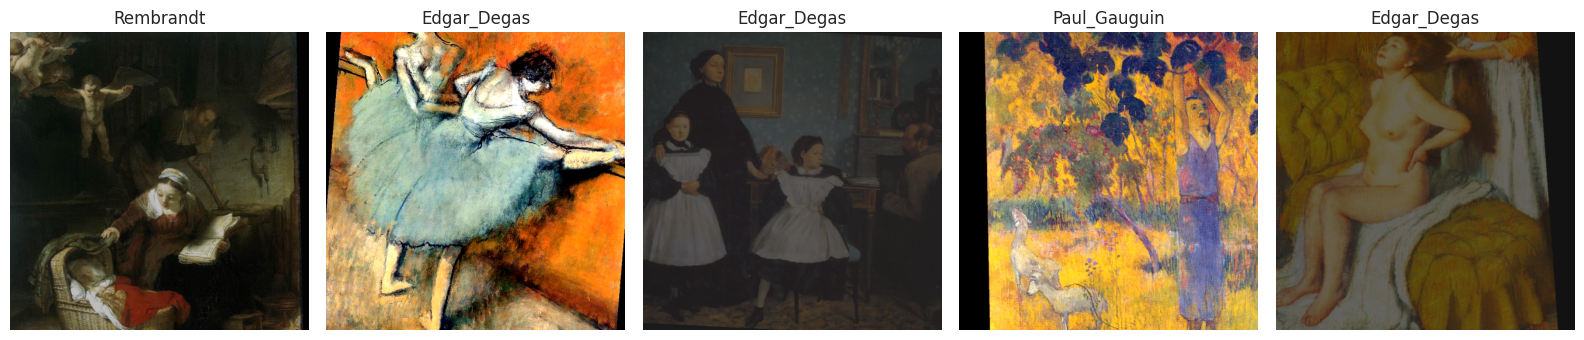

In [ ]:
sns.set_style(style='white')
fig, axs = plt.subplots(
    nrows=1, ncols=5, figsize=(16, 4),
    sharey=True, sharex=True
)

for i in range(5):
    idx = np.random.randint(low=0, high=2775)
    img, label = train_dataset_aug[idx]
    axs[i].set_title(train_dataset_aug.classes[label])
    axs[i].axis('off')
    axs[i].imshow(img.numpy().transpose((1, 2, 0)))
plt.tight_layout()

Выберите лучшую модель. Примените fine-tining модели
 на аугментированных данных. Получается ли улучшить качество?

In [ ]:
# Загрузим наилучшую модель
checkpoint = torch.load('/content/drive/MyDrive/Colab_Notebooks/DS_5term/week_11/model.ckpt')
model = FineTunedNet(to_freeze=6, n_classes=10)
model.load_state_dict(checkpoint['state_dict'])

<ipython-input-22-fe2d8dd93e6e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Colab_Notebooks/DS_5term/week_11/model.ckpt'

<All keys matched successfully>

In [ ]:
batch_size = 16

training_aug_loader = torch.utils.data.DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor='val_epoch_f1_score', mode='max')
wandb_logger = WandbLogger(project='ML.11', log_model='all')
trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[log_predictions_callback,
              checkpoint_callback],         # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=10)
trainer.fit(model, training_aug_loader, validation_loader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | resnext   | Sequential       | 23.0 M | train
2 | fc        | Linear           | 20.5 K | train
-------------------------------------------------------
21.6 M    Trainable params
1.4 M     Non-trainable params
23.0 M    Total params
92.002    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
train_epoch_f1_score,▄▃▄▆█▂▁▁▇█
train_loss,▃▇█▅▅▆▆▁▅▂▃▁▆▆▂▆▂▂▁▇▂▅▁▃▁▁▁▆▄▃▂▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_epoch_f1_score,▃▃▄▄▁▆▇██▇
val_loss,▅▆▅▅█▄▁▁▁▁
epoch,9
train_epoch_f1_score,0.1082
train_loss,0.08768
trainer/global_step,1739
val_epoch_f1_score,0.86887


**Вывод:** Как можно заметить метрика на валидационной выборке и правда стала больше. Это подтверждает полезность аугментации

<a name=vis></a>
### 5. Визуализация запусков и выводы



Визуализируйте графики лосса и метрики всех релевантных запусков. Для этого воспользуйтесь `wandb.Api()`, см. семинар. Сравните и сделайте выводы.

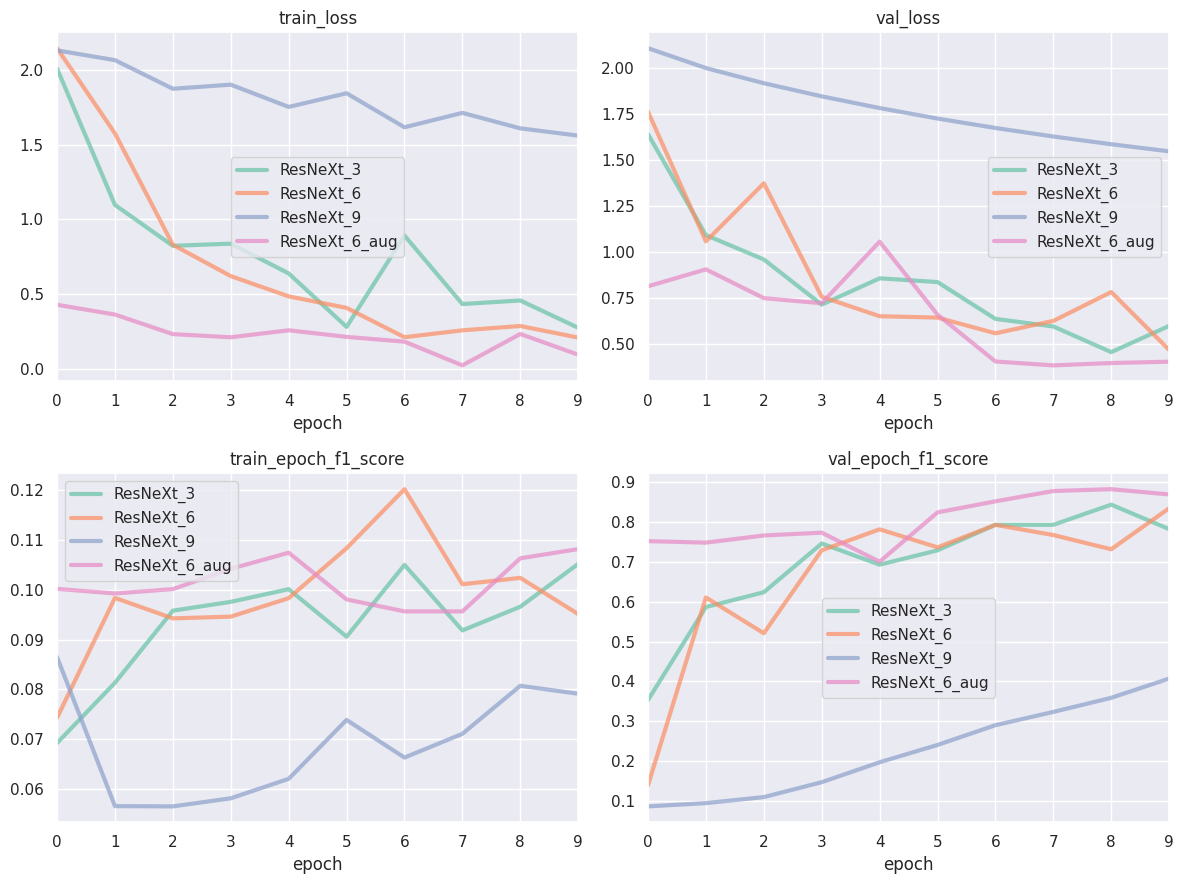

In [ ]:
models = wandb.Api().runs("ML.11")
plot_label = np.array([['train_loss', 'val_loss'],
                        ['train_epoch_f1_score', 'val_epoch_f1_score']])

with sns.axes_style('darkgrid'):
  fig, axs = plt.subplots(2, 2, figsize=(12, 9))

  for k in range(2):
    for m in range(2):
      axs[k, m].set_xlabel('epoch')
      axs[k, m].set_xlim(0, 9)

  for i, model in enumerate(models):
      df = model.history().groupby('epoch').mean(numeric_only=True)
      for k in range(2):
          for m in range(2):
              if model.name in ['ResNeXt_3', 'ResNeXt_6', 'ResNeXt_9', 'ResNeXt_6_aug']:
                axs[k, m].set_title(plot_label[k, m])
                axs[k, m].plot(df[plot_label[k, m]], lw=3, alpha=0.7, label=model.name)
                axs[k, m].legend()
  plt.tight_layout()

Сделайте общий вывод по задаче.

**Вывод:**
- В этой работе мы применили методы Transfer Learning, а именно дообучали модель ```resnext50_32x4d``` для задачи "угадывания автора по картине".
- Небольшой эксперемент показал, что использование модели, в которой примерно половина предобученной сети замороженна, а другая половина и классификатор обучаются на нашем датасете, показывает наибольший F1-score на валидационной выборке
- Также удалось получить еще больший F1-score, дообучив наилучшую модель на аугментированных данных. Именно такой результат и ожидался